In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ipywidgets
# %pip install torch
# %pip install scikit-learn
# %pip install tensorflow
# %pip install opencv-python
# %pip install matplotlib
# %pip install seaborn
# %pip install kagglehub
# %pip install monai
# %pip install imblearn
# %pip install ingenii-quantum-hybrid-networks

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.decomposition import PCA
from PIL import Image
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ingenii_quantum.hybrid_networks.layers import QuantumFCLayer

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths
##### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf {path}/chest_xray/chest_xray/train/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store

In [5]:
train_path_norm = f'{path}/chest_xray/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Count files in directory

In [6]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))])

print("Length train_path_norm:", count_images(train_path_norm))
print("Length train_path_pneu:", count_images(train_path_pneu))
print("Length test_path_norm:", count_images(test_path_norm))
print("Length test_path_pneu:", count_images(test_path_pneu))

Length train_path_norm: 1341
Length train_path_pneu: 3875
Length test_path_norm: 234
Length test_path_pneu: 390


#### Check data

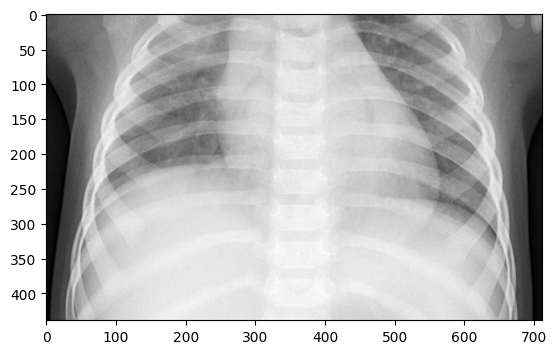

In [7]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

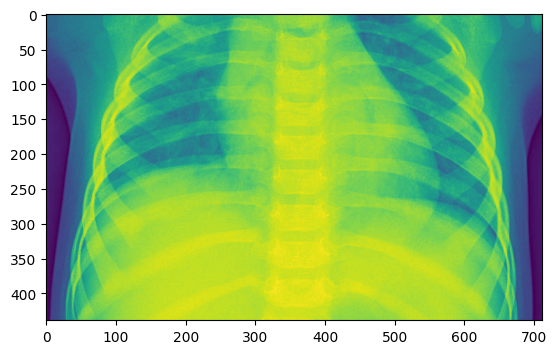

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [9]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(256, 256)):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

Found 5216 validated image filenames belonging to 2 classes.


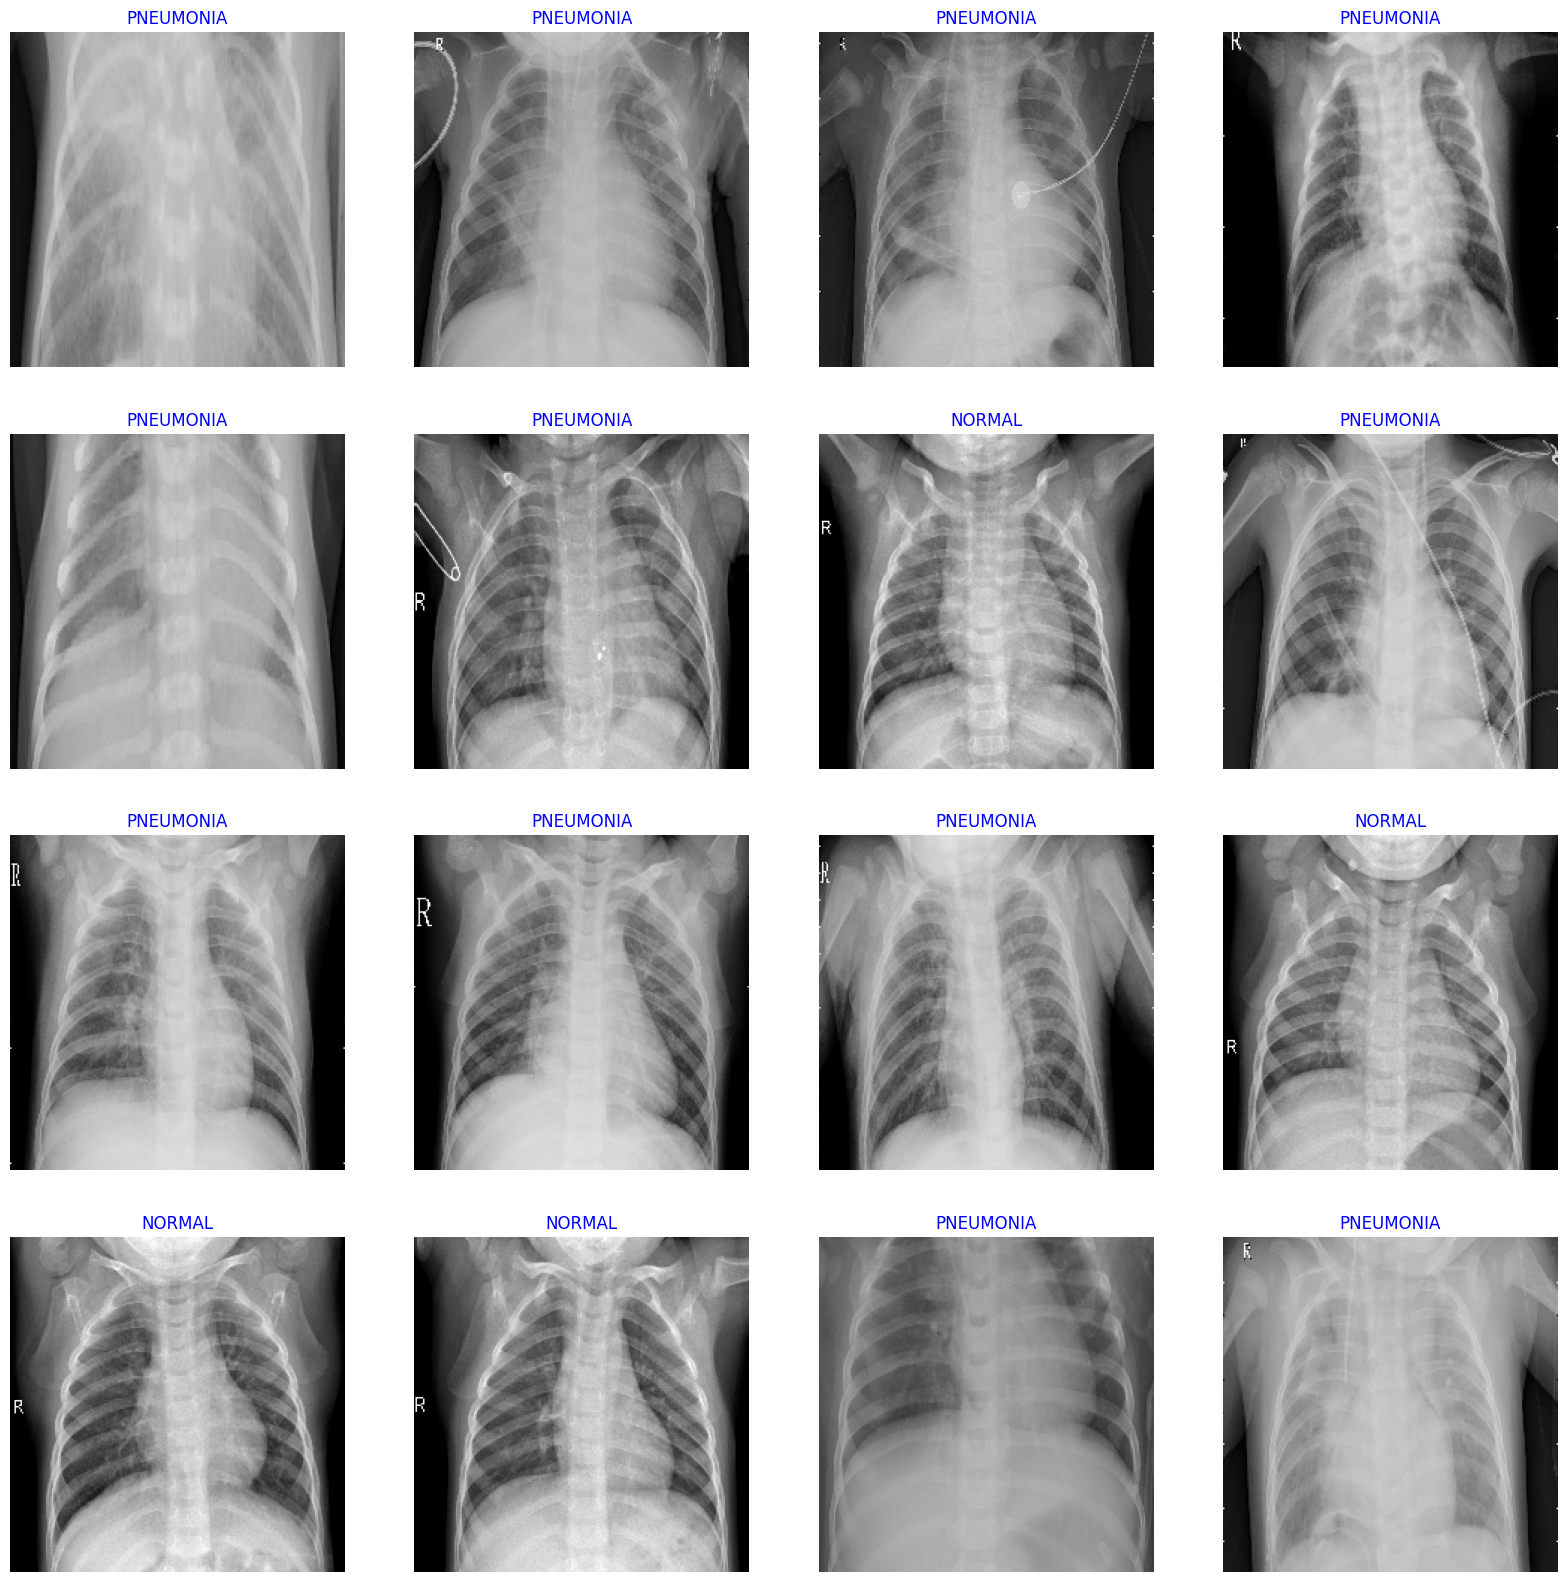

In [10]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### Proportional sampling for balanced dataset

In [11]:
num_samples = 400
num_samples_test = 80

norm_ratio = 1341 / (1341 + 3875)
pneu_ratio = 3875 / (1341 + 3875)

num_samples_norm = int(num_samples * norm_ratio)
num_samples_pneu = int(num_samples * pneu_ratio)

num_samples_norm_test = int(num_samples_test * norm_ratio)
num_samples_pneu_test = int(num_samples_test * pneu_ratio)

In [12]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, num_samples_norm, target_size=img_size)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, num_samples_pneu, target_size=img_size)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, num_samples_norm_test, target_size=img_size)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, num_samples_pneu_test, target_size=img_size)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)

#### Display the categorized file paths and labels

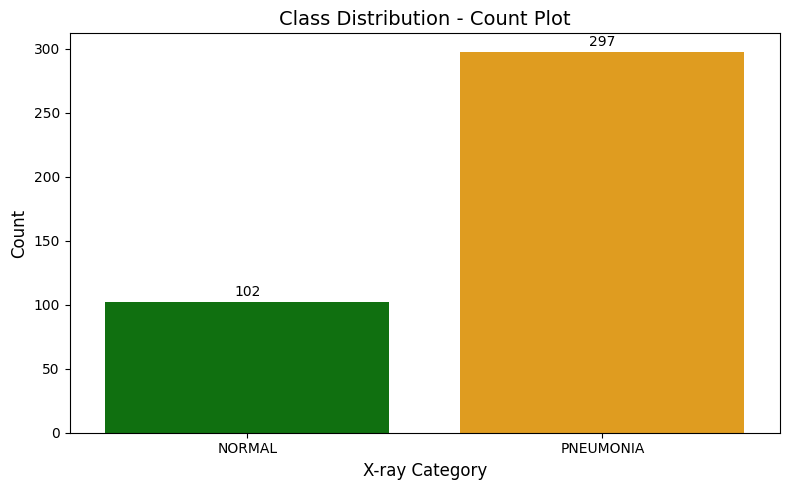

In [13]:
labels = train_labels_norm + train_labels_pneu

df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'PNEUMONIA' for lbl in labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'PNEUMONIA': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Quantum layer

In [14]:
num_qubits = 8

qnn_layer = QuantumFCLayer(
    input_size=num_qubits,
    n_layers=1,
    encoding='qubit',
    ansatz=1,
    observables=["Z" + "I" * (num_qubits - 1)],
    backend='default.qubit'
).create_layer(type_layer='torch')

#### Setting quantum model

In [15]:
class QuantumCNN(nn.Module):
    def __init__(self, num_classes=2, num_qubits=8):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global pooling and flattening
        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.flattened_size = 128 * 2 * 2

        self.quantum_layer = qnn_layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(513, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = self.global_pool(x)
        
        x = x.reshape(x.size(0), -1)

        quantum_input = x[:, :8]
        
        q_out = self.quantum_layer(quantum_input)
        
        # Concatenate classical CNN features with quantum output
        x = torch.cat((x, q_out), dim=1)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x


#### Initialize the model, criterion, optimizer

In [16]:
quantum_model = QuantumCNN(num_classes=2)

#### Training function

In [17]:
def fit_quantum_model(model, X_train, y_train, epochs=20, batch_size=32, patience=5):
    model.train()
    history = {'loss': [], 'accuracy': []}

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.view(X_batch.size(0), 3, 224, 224)
            optimizer.zero_grad()
            outputs = model(X_batch)
            num_classes = outputs.size(1)
            y_batch_one_hot = torch.nn.functional.one_hot(y_batch.to(torch.int64), num_classes=num_classes).float()
            loss = criterion(outputs, y_batch_one_hot)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            acc = (predicted == y_batch.to(torch.int64)).float().mean().item()
            epoch_accuracy += acc

        avg_epoch_loss = epoch_loss / len(data_loader)
        avg_epoch_accuracy = epoch_accuracy / len(data_loader)
        history['loss'].append(avg_epoch_loss)
        history['accuracy'].append(avg_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    return history


#### Training the model

In [18]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=20)

Epoch [1/20], Loss: 0.4930, Accuracy: 0.7487
Epoch [2/20], Loss: 0.3244, Accuracy: 0.8554
Epoch [3/20], Loss: 0.2534, Accuracy: 0.8699
Epoch [4/20], Loss: 0.2121, Accuracy: 0.9029
Epoch [5/20], Loss: 0.2173, Accuracy: 0.9248
Epoch [6/20], Loss: 0.2184, Accuracy: 0.8963
Epoch [7/20], Loss: 0.2153, Accuracy: 0.9053
Epoch [8/20], Loss: 0.1526, Accuracy: 0.9348
Epoch [9/20], Loss: 0.1354, Accuracy: 0.9396
Epoch [10/20], Loss: 0.1522, Accuracy: 0.9492
Epoch [11/20], Loss: 0.1608, Accuracy: 0.9303
Epoch [12/20], Loss: 0.1342, Accuracy: 0.9489
Epoch [13/20], Loss: 0.1476, Accuracy: 0.9441
Epoch [14/20], Loss: 0.1642, Accuracy: 0.9296
Epoch [15/20], Loss: 0.1189, Accuracy: 0.9372
Epoch [16/20], Loss: 0.1312, Accuracy: 0.9393
Epoch [17/20], Loss: 0.1156, Accuracy: 0.9615
Epoch [18/20], Loss: 0.0862, Accuracy: 0.9736
Epoch [19/20], Loss: 0.0647, Accuracy: 0.9639
Epoch [20/20], Loss: 0.1168, Accuracy: 0.9513


#### Plotting accuracy and loss

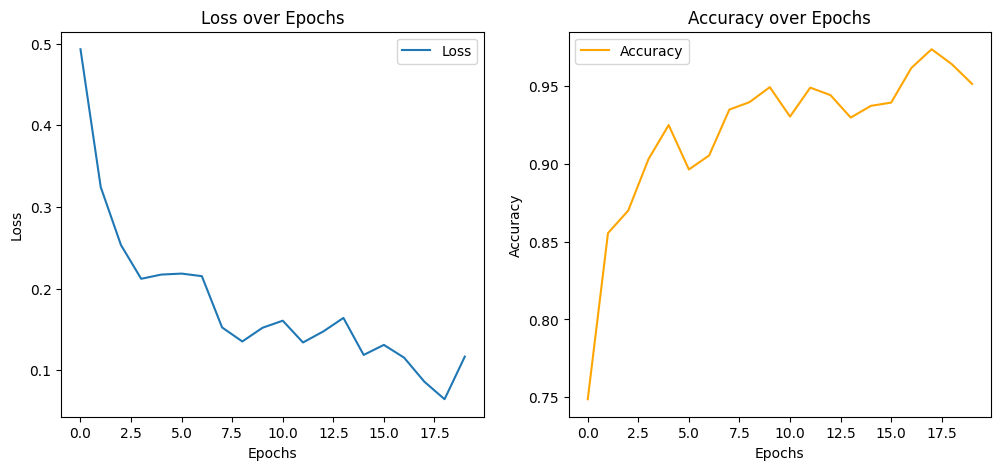

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(quantum_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(quantum_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### The evaluation of model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantum_model.to(device)

y_train_indices = torch.tensor(y_train, dtype=torch.long).to(device)  # Shape: (399,)
y_test_indices = torch.tensor(y_test, dtype=torch.long).to(device)    # Shape: (79,)

quantum_model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  # Shape: (79, 3, 224, 224)

#### Evaluate performance

In [21]:
X_test_tensor = X_test_tensor.view(-1, 3, 224, 224).to(device)

with torch.no_grad():
    outputs = quantum_model(X_test_tensor)

y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
y_test_labels = y_test_indices.cpu().numpy()

print(f"Test Accuracy: {metrics.accuracy_score(y_test_labels, y_pred) * 100:.2f}%")
print(metrics.classification_report(y_test_labels, y_pred, target_names=['Normal', 'Pneumonia']))


Test Accuracy: 79.75%
              precision    recall  f1-score   support

      Normal       0.59      0.65      0.62        20
   Pneumonia       0.88      0.85      0.86        59

    accuracy                           0.80        79
   macro avg       0.73      0.75      0.74        79
weighted avg       0.80      0.80      0.80        79



#### Compute evaluation metrics

In [22]:
y_test_labels = torch.tensor(y_test).numpy()

if y_pred.ndim == 1:
    y_pred_labels = y_pred
else:
    y_pred_labels = torch.argmax(torch.tensor(y_pred), dim=1).numpy()

classification_rep = metrics.classification_report(y_test_labels, y_pred_labels, output_dict=True, zero_division=True)
conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
roc_auc = metrics.roc_auc_score(y_test_labels, y_pred_labels)

print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")


Classification Report:
 {'0': {'precision': 0.5909090909090909, 'recall': 0.65, 'f1-score': 0.6190476190476191, 'support': 20.0}, '1': {'precision': 0.8771929824561403, 'recall': 0.847457627118644, 'f1-score': 0.8620689655172413, 'support': 59.0}, 'accuracy': 0.7974683544303798, 'macro avg': {'precision': 0.7340510366826156, 'recall': 0.748728813559322, 'f1-score': 0.7405582922824302, 'support': 79.0}, 'weighted avg': {'precision': 0.8047160478872671, 'recall': 0.7974683544303798, 'f1-score': 0.8005445740059446, 'support': 79.0}}
Confusion Matrix:
 [[13  7]
 [ 9 50]]
ROC AUC Score: 0.748728813559322


#### Predicted probability for Positive Class

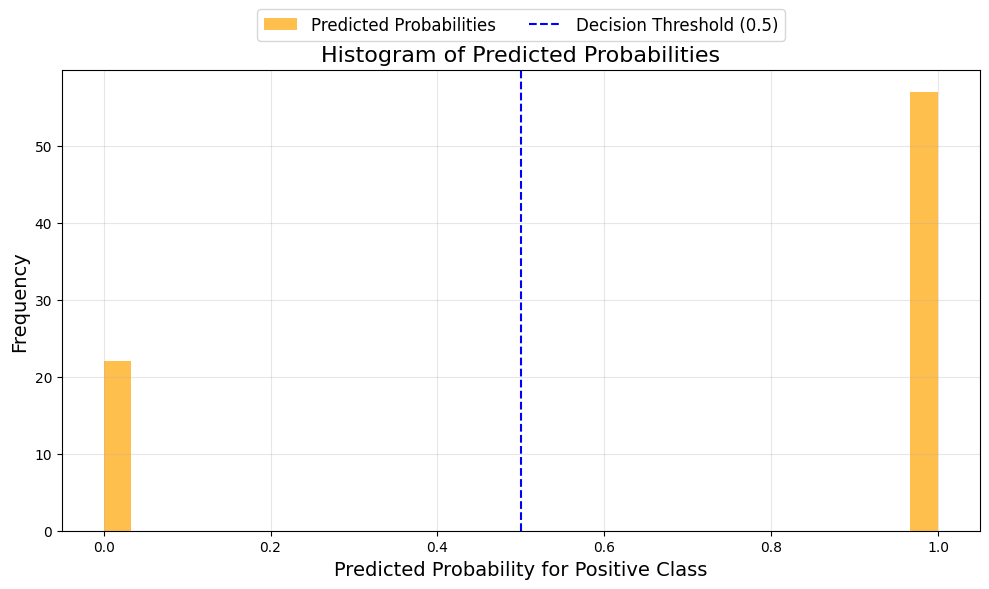

In [23]:
y_pred_probabilities_tensor = torch.tensor(y_pred, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

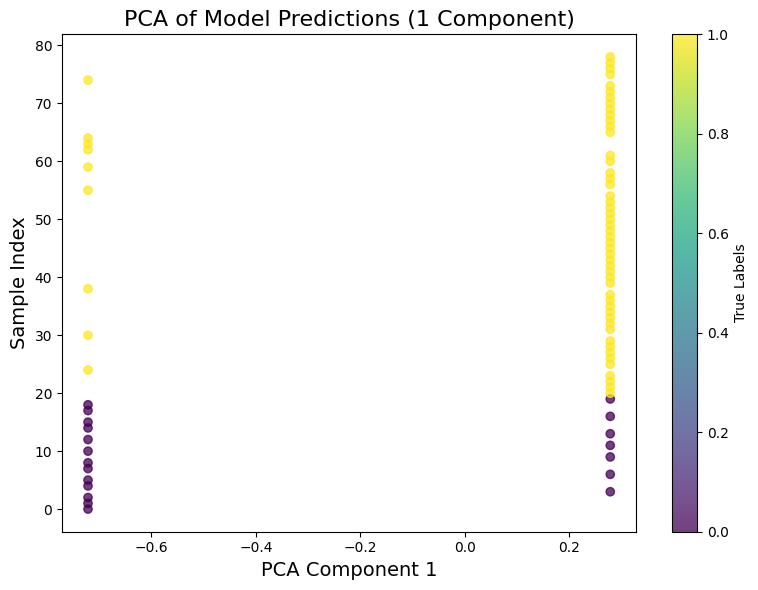

In [24]:
if y_test.ndim > 1:
    y_test_labels = torch.argmax(torch.tensor(y_test), dim=1).numpy()
else:
    y_test_labels = torch.tensor(y_test).numpy()

labels_test_reshaped = y_pred.reshape(-1, 1)
pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()


#### Plot the confusion matrix

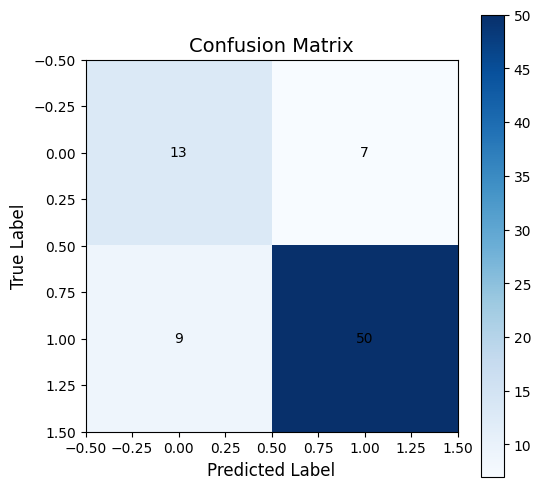

In [25]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()